In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv3D, Dense, Activation, Softmax, MaxPooling2D, MaxPooling3D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cv2
import os
from tqdm import tqdm

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

/Users/user/Documents/проекты/NN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
data_path = './data/natural_images/'

In [4]:
classes = [
    'airplane',
    'car',
    'cat',
    'dog',
    'flower',
    'fruit',
    'motorbike',
    'person'
]

In [5]:
def create_dataframe(dataset_path):
    data = {
        'path': [],
        'class': []
    }

    for class_ in classes:
        for i in os.listdir(dataset_path + class_):
            data['path'].append(i)
            data['class'].append(class_)
    
    return pd.DataFrame(data)


In [6]:
data = create_dataframe(data_path)

In [7]:
data

,path,class
0,airplane_0412.jpg,airplane
1,airplane_0374.jpg,airplane
2,airplane_0360.jpg,airplane
3,airplane_0406.jpg,airplane
4,airplane_0348.jpg,airplane
...,...,...
6894,person_0449.jpg,person
6895,person_0461.jpg,person
6896,person_0307.jpg,person
6897,person_0313.jpg,person


In [8]:
dataset = {
    'image': [],
    'class': []
}

In [9]:
for i in tqdm(data.itertuples()):
    class_ = i[2]
    image_path = i[1]
    image = cv2.imread(f"{data_path + class_}/{image_path}")
    image = cv2.resize(image, (100, 100))

    dataset['image'].append(image)

    label = [0, 0, 0, 0, 0, 0, 0, 0] # для Softmax
    label[classes.index(class_)] = 1
    dataset['class'].append(label)

0it [00:00, ?it/s]

6899it [00:03, 1968.96it/s]


In [10]:
images = np.array(dataset['image'], dtype="float") / 255 # создаём из списка массив и нормируем изображения на 1
classes = np.array(dataset['class'])

In [11]:
with open("images.pickle", 'wb') as f:
  pickle.dump(images, f)

In [12]:
with open("classes.pickle", 'wb') as f:
  pickle.dump(classes, f)

In [13]:
with open("images.pickle", 'rb') as f:
  X = pickle.load(f)

with open("classes.pickle", 'rb') as f:
  y = pickle.load(f)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [36]:
model = Sequential()
inputShape = (100, 100, 3)
chanDim = -1
    # CONV => RELU => BN => POOL
model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
  # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(100, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(100, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
  # first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(8))
model.add(Activation("softmax"))
# return the constructed network architecture

/Users/user/Documents/проекты/NN/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# optimizer = SGD(learning_rate=0.001, nesterov=True)

In [38]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]
              )  

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 100, 100, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 100, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 100)    │        14,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 25, 25, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 100)    │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 25, 25, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 25, 100)    │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,971,040 (7.52 MB)

 Trainable params: 1,970,304 (7.52 MB)

 Non-trainable params: 736 (2.88 KB)

In [41]:
checkpoints = ModelCheckpoint(filepath='checkpoints.keras', verbose=1, save_best_only=True)

In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=10, batch_size=32,
              shuffle=True,
              callbacks=[checkpoints])

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8295 - loss: 0.5152
Epoch 1: val_loss improved from 0.33930 to 0.33429, saving model to checkpoints_sgd.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8295 - loss: 0.5151 - val_accuracy: 0.8725 - val_loss: 0.3343
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8443 - loss: 0.4659
Epoch 2: val_loss improved from 0.33429 to 0.33412, saving model to checkpoints_sgd.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.8442 - loss: 0.4660 - val_accuracy: 0.8773 - val_loss: 0.3341
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8479 - loss: 0.4366
Epoch 3: val_loss did not improve from 0.33412
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.8479 - loss: 0.4366 - val_accuracy: 0.8686 - val_loss: 0.3346
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8490 - loss: 0.4311
Epoch 4: val_loss did not improve from 0.33412
184/184 ━━━━━━

In [28]:
model = tf.keras.models.load_model("checkpoints.keras")

In [29]:
predictions = model.predict(X_test, batch_size=32)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [30]:
classes = [
    'airplane',
    'car',
    'cat',
    'dog',
    'flower',
    'fruit',
    'motorbike',
    'person'
]

In [31]:
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classes))

              precision    recall  f1-score   support

    airplane       0.98      0.96      0.97       112
         car       0.99      0.99      0.99       150
         cat       0.82      0.81      0.82       131
         dog       0.74      0.75      0.75       113
      flower       0.98      0.97      0.97       130
       fruit       0.99      1.00      1.00       135
   motorbike       1.00      1.00      1.00       109
      person       0.98      1.00      0.99       155

    accuracy                           0.94      1035
   macro avg       0.93      0.93      0.93      1035
weighted avg       0.94      0.94      0.94      1035



In [32]:
loss, acc = model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9288 - loss: 0.1930


In [33]:
acc

0.938164234161377

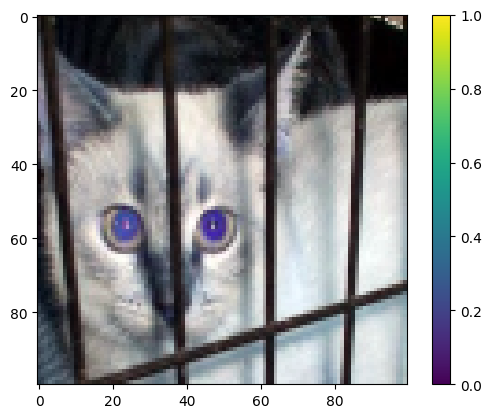

In [53]:
plt.figure()
plt.imshow(X_test[555])
plt.colorbar()
plt.grid(False)

In [50]:
np.argmax(predictions[555])

3

In [51]:
y_test[555]

array([0, 0, 1, 0, 0, 0, 0, 0])

In [46]:
classes

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']